In [ ]:
import os
import cv2

#MODEL            = 'haarcascade_frontalface_default.xml'
MODEL             = './MODEL/cascade.xml'
TRAGET_FILES     = ['real_00001.jpg', 'real_00003.jpg', 'real_00004.jpg', 'real_00008.jpg', 'real_00018.jpg', 'real_00025.jpg']
CHECK_FILES      = ['real_00004.jpg', 'real_00008.jpg']
TARGET_FILE_PATH = 'OK'
FACTOR           = 1.1
THICK            = 3
RED              = (0, 0, 255)
OUTPUT_PREFIX    = 'result_'

def detect_write(cascade, fname, scale = FACTOR) :
    """ １つの画像の顔検出を行う
    Arg:
        cas   : cv2.CascadeClassifier
        fname : str : ファイル名
    """
    fpath    = os.path.join(TARGET_FILE_PATH, fname)
    img      = cv2.imread(fpath)
    gray     = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces    = cascade.detectMultiScale(gray, scaleFactor = scale) # scaleFactorを調べたい
    
    for (x, y, w, h) in faces :
        cv2.rectangle(img, (x, y), (x + w, y + h),  color = RED, thickness = THICK)
        
    output_file = OUTPUT_PREFIX + fname
    output_path = os.path.join(TARGET_FILE_PATH, output_file)
    ret = cv2.imwrite(output_path, img)
    return faces

def findout_all_files(target = TRAGET_FILES, scale = FACTOR) :
    cascade = cv2.CascadeClassifier(MODEL)
    for fn in target :  # test data (TARGET_FILES) loop
        faces = detect_write(cascade, fn, scale = scale)
        #print("-------------------------------")
        #print('file =', fn)
        #print('faces =', faces)
        #print("-------------------------------")
    return

findout_all_files(target = TRAGET_FILES, scale = 1.1) # チェック対象のみ処理する scale = 2.0 がベスト?


1.  画像を大量（理想は7000）に集める　NG画像が最低でも20はいる
2.  顔認認識モデルを学習するためのツールの生成パラメータを調整する
3.  顔認識プログラムのパラメータを調整する


In [ ]:
import tensorflow as tf

tf.__version__

2025-02-27 14:59:28.306234: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-02-27 14:59:28.306270: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-02-27 14:59:28.306279: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-02-27 14:59:28.306315: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-27 14:59:28.306329: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/30


2025-02-27 14:59:29.864470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-02-27 14:59:29.934567: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


938/938 [==============================] - 11s 10ms/step - loss: 0.2402 - val_loss: 0.1944
Epoch 2/30
938/938 [==============================] - 9s 10ms/step - loss: 0.1684 - val_loss: 0.1481
Epoch 3/30
938/938 [==============================] - 9s 10ms/step - loss: 0.1389 - val_loss: 0.1305
Epoch 4/30
938/938 [==============================] - 10s 10ms/step - loss: 0.1264 - val_loss: 0.1210
Epoch 5/30
938/938 [==============================] - 10s 10ms/step - loss: 0.1170 - val_loss: 0.1133
Epoch 6/30
938/938 [==============================] - 10s 10ms/step - loss: 0.1116 - val_loss: 0.1088
Epoch 7/30
938/938 [==============================] - 10s 10ms/step - loss: 0.1069 - val_loss: 0.1047
Epoch 8/30
938/938 [==============================] - 9s 10ms/step - loss: 0.1031 - val_loss: 0.1022
Epoch 9/30
938/938 [==============================] - 9s 10ms/step - loss: 0.1009 - val_loss: 0.1005
Epoch 10/30
938/938 [==============================] - 9s 10ms/step - loss: 0.0995 - val_loss: 0.

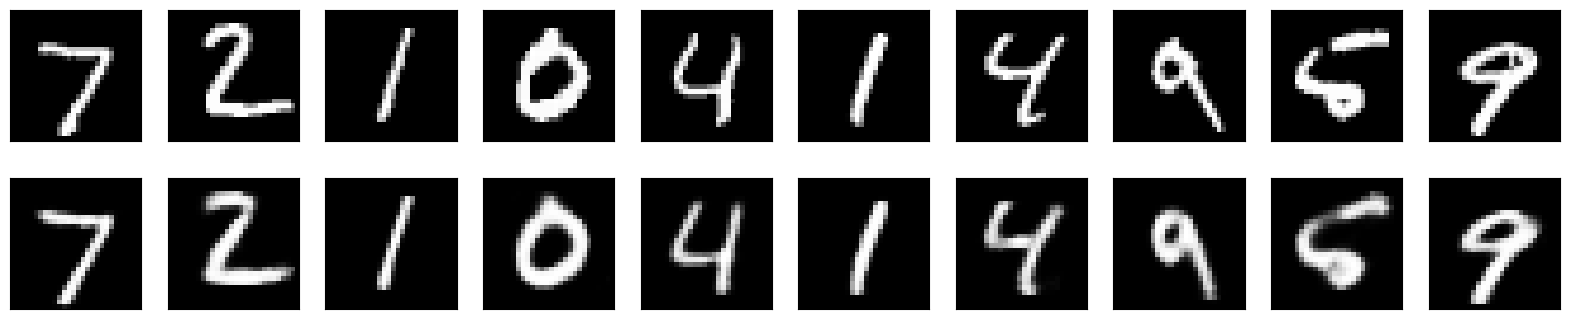

In [1]:
from numpy import random
import numpy as np
from matplotlib.lines import Line2D  
from PIL import Image

random.seed(42)  # @UndefinedVariable

from tensorflow.keras.datasets import mnist , fashion_mnist, cifar100
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

CASE = "mnist"  # mnist, fashion_mnist, cifar100
OBJ  = {"mnist":mnist, "fashion":fashion_mnist, "cifar100":cifar100}

# 学習前のデータ準備
(x_train, _), (x_test, _) = OBJ[CASE].load_data()
x_train = x_train.astype('float32') / 255.
x_test  = x_test.astype('float32') / 255.   
ENC_ACT, DEC_ACT = 'relu', 'sigmoid'            
    
WIDTH, HEIGHT, CL = x_train.shape[1], x_train.shape[2], 1
encoding_dim, decoding_dim, EPOCH, BATCH_SIZE = 32, WIDTH * HEIGHT * CL, 30, 64
x_train = np.reshape(x_train, [-1, x_train.shape[1] * x_train.shape[2] * CL])
x_test  = np.reshape(x_test, [-1, x_test.shape[1] * x_test.shape[2] * CL])

# encode
input_img    = Input(shape=(x_train.shape[1], ), name = "autoencoder" + "_input")
encoded      = Dense(encoding_dim, activation=ENC_ACT)(input_img)
encoded      = Flatten(name='flatten_e1')(encoded)
encoded      = Dense(encoding_dim, activation=ENC_ACT)(encoded)
encoded      = Flatten(name='flatten_e2')(encoded)
encoded      = Dense(encoding_dim, activation=ENC_ACT)(encoded)
encoded      = Flatten(name='flatten_e3')(encoded)
encoded      = Dense(encoding_dim, activation=ENC_ACT)(encoded)
encoded      = Flatten(name='flatten_e4')(encoded)
encoded      = Dense(encoding_dim, activation=ENC_ACT)(encoded)  
# decode
decoded      = Dense(decoding_dim, activation=DEC_ACT)(encoded)
decoded      = Flatten(name='flatten_d1')(decoded)
decoded      = Dense(decoding_dim, activation=DEC_ACT)(decoded)
decoded      = Flatten(name='flatten_d2')(decoded)
decoded      = Dense(decoding_dim, activation=DEC_ACT)(decoded)
decoded      = Flatten(name='flatten_d3')(decoded)
decoded      = Dense(decoding_dim, activation=DEC_ACT)(decoded)
decoded      = Flatten(name='flatten_d4')(decoded)
decoded      = Dense(decoding_dim, activation=DEC_ACT)(decoded)

autoencoder  = Model(input_img, decoded)

opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

autoencoder.compile(optimizer=opt, loss='binary_crossentropy')

hist = autoencoder.fit(x_train, x_train, epochs=EPOCH, batch_size=BATCH_SIZE, shuffle=True, validation_data=(x_test, x_test))

def results_draw(x_test, decode_imgs, d_size) :
      
    """Draw Autoencoder Results
    """
      
    import matplotlib.pyplot as plt
      
    # 何個表示するか
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # オリジナルのテスト画像を表示
        ax = plt.subplot(2, n, i+1)
        plt.imshow(x_test[i].reshape(d_size[0], d_size[1], d_size[2]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        # 変換された画像を表示
        ax = plt.subplot(2, n, i+1+n)
        plt.imshow(decoded_imgs[i].reshape(d_size[0], d_size[1], d_size[2]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.savefig("autoencoder_results.png")

decoded_imgs = autoencoder.predict(x_test)
results_draw(x_test, decoded_imgs, (WIDTH, HEIGHT, CL))

In [ ]:
from matplotlib.lines import Line2D